**02_BCF2SS Model___BCF___Block-Centered Flow Package**

In [1]:
import os ; import pathlib as pl ; import flopy ; import git ; import matplotlib as mpl ; import matplotlib.pyplot as plt; import pandas as pd
import numpy as np ; from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env, timed; from pathlib import Path 

write = get_env("WRITE", True)   ; run = get_env("RUN", True)    ; plot = get_env("PLOT", True) 
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True) ; current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\00_MF6


In [2]:
sim_name = "ex-gwf-bcf2ss" ; output_folder = Path("./02_BCF2SS Model")        ; output_folder.mkdir(exist_ok=True)  
fname = "wetdry01.txt"     ; fpath = ('E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-bcf2ss')     
data_file_with_path = os.path.join(fpath, fname)                              ; workspace = output_folder  ; figs_path = output_folder

In [3]:
wetdry_layer0 = np.loadtxt(data_file_with_path)    ; np.savetxt(workspace/"a_wetdry_layer0.csv", wetdry_layer0, delimiter = ",")

In [4]:
length_units = "feet" ; time_units = "days"
parameters = {"ex-gwf-bcf2ss-p01a": {"rewet": True,"wetfct": 1.0,"iwetit": 1,"ihdwet": 0,"linear_acceleration": "cg","newton": None},
              "ex-gwf-bcf2ss-p02a": {"rewet": False,"wetfct": None,"iwetit": None,"ihdwet": None,"linear_acceleration": "bicgstab","newton": "NEWTON"}}

nper = 2 ;  nlay = 2 ;  nrow = 10 ;  ncol = 15 ;  delr = 500 ;  delc = 500 ;  top = 150 ;  
botm_str = "50.0,-50." ;  icelltype_str = "1,0" ;  k11_str = "10.0,5.0" ;  
k33 = 0.1 ;  strt = 0 ;  recharge = 0.004 ;  nouter = 500 ;  ninner = 100 ;  hclose = 0.000001 ;  rclose = 0.001 ;  relax = 0.97 ;  

tdis_ds = ((1.0, 1.0, 1),(1.0, 1.0, 1),)
botm = [float(value) for value in botm_str.split(",")]             # Parse parameter strings into tuples
icelltype = [int(value) for value in icelltype_str.split(",")]     ; k11 = [float(value) for value in k11_str.split(",")]
wel_spd = {1: [[1, 2, 3, -35000.0],[1, 7, 3, -35000.0],]}
riv_spd = {0: [[1, i, 14, 0.0, 10000.0, -5] for i in range(nrow)]}

In [5]:
def build_models(name, rewet, wetfct, iwetit, ihdwet, linear_acceleration, newton):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim,linear_acceleration=linear_acceleration,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,
        inner_dvclose=hclose,rcloserecord=f"{rclose} strict",relaxation_factor=relax)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True, newtonoptions=newton)
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    if rewet:
        rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet]       ; wetdry = [wetdry_layer0, 0]
    else:
        rewet_record = None  ; wetdry = None

    flopy.mf6.ModflowGwfnpf(gwf,rewet_record=rewet_record,wetdry=wetdry,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True)
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim

def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)  ; assert success, buff

In [6]:
def plot_simulated_results(num, gwf, ho, co, silent=True):
    with styles.USGSMap():
        botm_arr = gwf.dis.botm.array

        fig = plt.figure(figsize=(6.8, 6), constrained_layout=False)
        gs = mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5)
        plt.axis("off")

        ax1 = fig.add_subplot(gs[:3, :5]) ; ax2 = fig.add_subplot(gs[:3, 5:], sharey=ax1)  ; ax3 = fig.add_subplot(gs[3:6, :5], sharex=ax1)
        ax4 = fig.add_subplot(gs[3:6, 5:], sharex=ax1, sharey=ax1) ; ax5 = fig.add_subplot(gs[6, :])  ; axes = [ax1, ax2, ax3, ax4, ax5]

        labels = ("A", "B", "C", "D") ; aquifer = ("Upper aquifer", "Lower aquifer")  ; cond = ("natural conditions", "pumping conditions")
        vmin, vmax = -10, 140 ; masked_values = [1e30, -1e30] ; levels = [np.arange(0, 130, 10), (10, 20, 30, 40, 50, 55, 60)] ; plot_number = 0
        for idx, totim in enumerate((1, 2)):
            head = ho.get_data(totim=totim)   ; head[head < botm_arr] = -1e30
            qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(co.get_data(text="DATA-SPDIS", kstpkper=(0, totim - 1))[0], gwf)

            for k in range(nlay):
                ax = axes[plot_number] ; ax.set_aspect("equal")
                mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=k)  ; mm.plot_grid(lw=0.5, color="0.5")
                cm = mm.plot_array(head, masked_values=masked_values, vmin=vmin, vmax=vmax)
                mm.plot_bc(ftype="WEL", kper=totim - 1) ; mm.plot_bc(ftype="RIV", color="green", kper=0) ; 
                mm.plot_vector(qx, qy, normalize=True, color="0.75")
                cn = mm.contour_array(head,masked_values=masked_values,levels=levels[idx],colors="black",linewidths=0.5,)
                
                plt.clabel(cn, fmt="%3.0f") ; heading = f"{aquifer[k]} under\n{cond[totim - 1]}"
                styles.heading(ax, letter=labels[plot_number], heading=heading) ; styles.remove_edge_ticks(ax) ; plot_number += 1

        ax1.set_ylabel("y-coordinate, in feet") ; ax3.set_ylabel("y-coordinate, in feet")
        ax3.set_xlabel("x-coordinate, in feet") ; ax4.set_xlabel("x-coordinate, in feet")

        ax = axes[-1] ; ax.set_ylim(1, 0)   ; ax.set_xlim(-5, 5) ; ax.set_xticks([])  ; ax.set_yticks([])
        ax.spines["top"].set_color("none")  ; ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none") ; ax.spines[ "right"].set_color("none")    ; ax.patch.set_alpha(0.0)

        ax.plot(-1000, -1000, "s", ms=5, color="green", mec="black", mew=0.5, label="River")
        ax.plot(-1000, -1000, "s", ms=5, color="red", mec="black", mew=0.5, label="Well")
        ax.plot(-1000,-1000,"s",ms=5,color="none",mec="black",mew=0.5,label="Dry cell")
        ax.plot(-10000,-10000,lw=0,marker="$\u2192$",ms=10,mfc="0.75",mec="0.75",label="Normalized specific discharge")
        # ax.plot(-1000,-1000,lw=0.5,color="black",label="Head, in feet")
        styles.graph_legend(ax, ncol=5, frameon=False, loc="upper center")

        cbar = plt.colorbar(cm, ax=ax, shrink=0.5, orientation="horizontal", location="bottom")  ; cbar.ax.set_xlabel("Head, in feet")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-{num:02d}.png")


def plot_results(silent=True):
    if not plot:
        return

    if silent:
        verbosity_level = 0
    else:
        verbosity_level = 1

    with styles.USGSMap():
        name = next(iter(parameters.keys()))  ; sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level)
        gwf = sim.get_model(sim_name)

        hobj = gwf.output.head()  ;   cobj = gwf.output.budget()  ;  head = hobj.get_data(totim=1)

        fig = plt.figure(figsize=(6.8, 3.5), constrained_layout=True)
        gs = mpl.gridspec.GridSpec(nrows=8, ncols=10, figure=fig, hspace=40, wspace=10)  ; plt.axis("off")

        ax = fig.add_subplot(gs[:7, 0:7])  ; ax.set_aspect("equal")  
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)          ; mm.plot_bc(ftype="WEL", kper=1, plotAll=True)
        mm.plot_bc(ftype="RIV", color="green", plotAll=True)   ; mm.plot_grid(lw=0.5, color="0.5")
        ax.set_ylabel("y-coordinate, in feet")                 ; ax.set_xlabel("x-coordinate, in feet")
        styles.heading(ax, letter="A", heading="Map view")     ; styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(gs[:5, 7:])
        mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 7})     ; mm.plot_array(np.ones((nlay, nrow, ncol)), head=head, cmap="jet")
        mm.plot_bc(ftype="WEL", kper=1)      ; mm.plot_bc(ftype="RIV", color="green", head=head)   ; mm.plot_grid(lw=0.5, color="0.5")
        ax.set_ylabel("Elevation, in feet")  ; ax.set_xlabel("x-coordinate along \nrow 8, in feet")
        styles.heading(ax, letter="B", heading="Cross-section view")    ; styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(gs[7, :]) ; ax.set_xlim(0, 1) ; ax.set_ylim(0, 1) ; ax.set_xticks([]) ; ax.set_yticks([])
        ax.spines["top"].set_color("none") ; ax.spines["bottom"].set_color("none") ; ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)
        ax.plot(-1100, -1100, "s", ms=5, color="green", mec="black", mew=0.5, label="River")
        ax.plot(-1100, -1100, "s", ms=5, color="red", mec="black", mew=0.5, label="Well")
        ax.plot(-1100,-1100,"s",ms=5,color="blue",mec="black",mew=0.5,label="Steady-state water table")
        styles.graph_legend(ax, ncol=3, frameon=False, loc="upper center")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)

        # figure with wetdry array
        fig = plt.figure(figsize=(4.76, 3), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect("equal")
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
        wd = mm.plot_array(wetdry_layer0)
        mm.plot_grid(lw=0.5, color="0.5")
        cbar = plt.colorbar(wd, shrink=0.5)
        cbar.ax.set_ylabel("WETDRY parameter")
        ax.set_ylabel("y-coordinate, in feet")
        ax.set_xlabel("x-coordinate, in feet")
        styles.remove_edge_ticks(ax)

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-01.png")

        plot_simulated_results(2, gwf, hobj, cobj)

        name = list(parameters.keys())[1]  ; sim_ws = os.path.join(workspace, name) 
        sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level)
        gwf = sim.get_model(sim_name)

        hobj = gwf.output.head()
        cobj = gwf.output.budget()
        plot_simulated_results(3, gwf, hobj, cobj)

### Running the example

Define a function to run the example scenarios.

In [7]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Solve the model by the default means.

In [8]:
scenario(0)

run_models took 133.95 ms


Solve the model with the Newton-Raphson formulation.

In [9]:
scenario(1)

run_models took 134.62 ms


Plot results.

C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


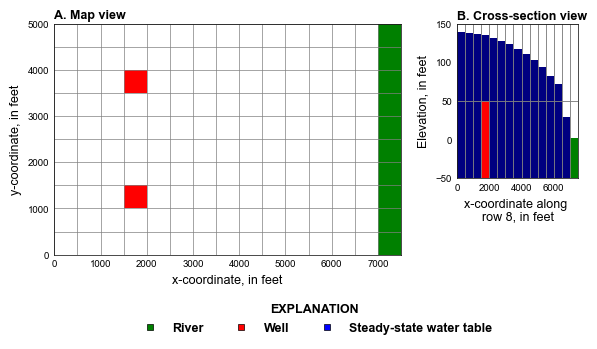

C:\Users\gross.DESKTOP-AIRQM2M\AppData\Local\Temp\ipykernel_3376\2280060382.py:95: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(fpth)


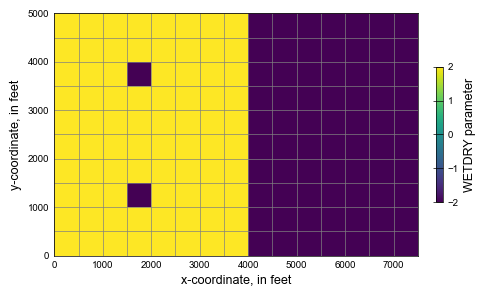

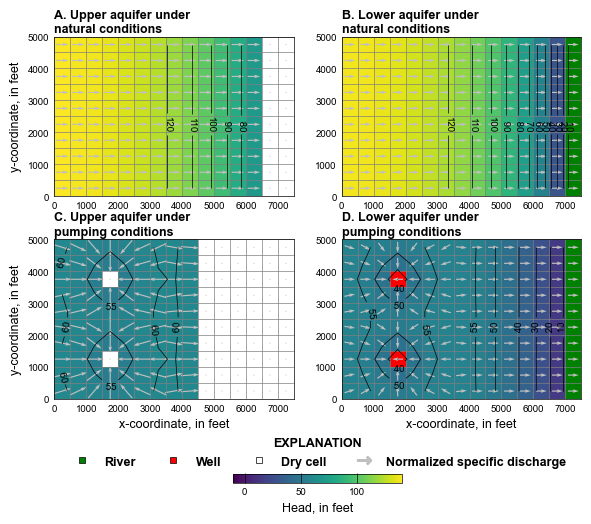

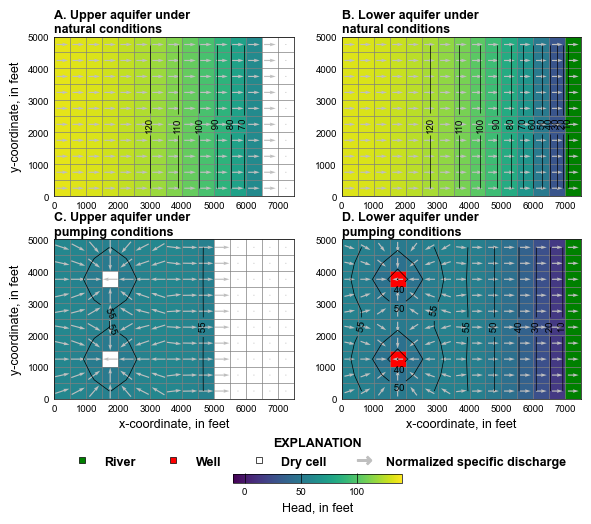

In [10]:
if plot:
    # Simulated water levels and normalized specific discharge vectors in the
    # upper and lower aquifers under natural and pumping conditions using (1) the
    # rewetting option in the Node Property Flow (NPF) Package with the
    # Standard Conductance Formulation and (2) the Newton-Raphson formulation.
    # A. Upper aquifer results under natural conditions. B. Lower aquifer results
    # under natural conditions C. Upper aquifer results under pumping conditions.
    # D. Lower aquifer results under pumping conditions
    plot_results()